In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data preparation

In [2]:
y_columns = ["AGE", "SEX_ID (1=m, 2=f)"]
drop_columns = ["Unnamed: 0", "Subject", "HEIGHT", "ETHNIC_ID", "WEIGHT", "MARITAL_ID", "OCCUPATION_ID", "QUALIFICATION_ID", "DOB", "DATE_AVAILABLE", "STUDY_DATE"]

In [3]:
df_main = pd.read_csv(r"ixi_tabular.csv").dropna()
df_main = df_main.drop(columns=drop_columns)

In [4]:
train_df, valid_df = train_test_split(df_main, test_size=0.2, random_state=42)

In [5]:
train_X, train_y = train_df.drop(columns=y_columns), train_df[y_columns]
valid_X, valid_y = valid_df.drop(columns=y_columns), valid_df[y_columns]

In [6]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X.copy(deep=True))
val_X = scaler.transform(valid_X.copy(deep=True))

## Data exploration

<AxesSubplot: >

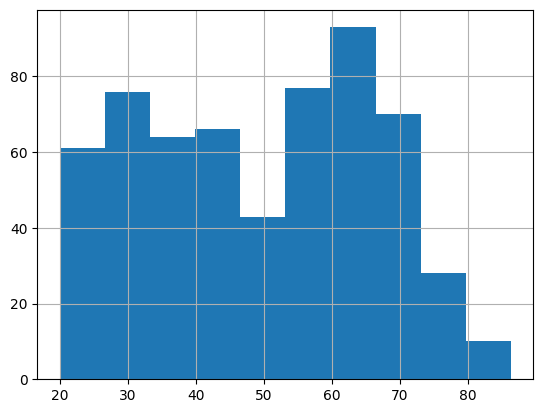

In [7]:
df_main["AGE"].hist()

In [8]:
df_main["SEX_ID (1=m, 2=f)"].value_counts() / len(df_main)

2    0.557823
1    0.442177
Name: SEX_ID (1=m, 2=f), dtype: float64

<AxesSubplot: >

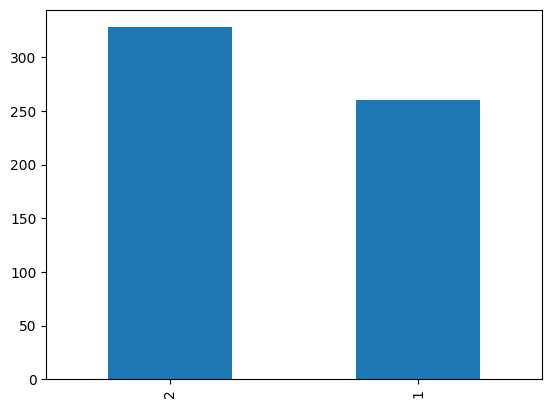

In [9]:
df_main["SEX_ID (1=m, 2=f)"].value_counts().plot(kind="bar")

## Classification

In [10]:
le = LabelEncoder()
le.fit(train_y["SEX_ID (1=m, 2=f)"])
train_y_classification = le.transform(train_y["SEX_ID (1=m, 2=f)"])
val_y_classification = le.transform(valid_y["SEX_ID (1=m, 2=f)"])

In [11]:
model_classification = xgb.XGBClassifier()
model_classification.fit(train_X, train_y_classification)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred_val = model_classification.predict(val_X)
acc_val = accuracy_score(val_y_classification, y_pred_val)
print(f"Validation accuracy: {acc_val}")
balanced_accuracy_val = balanced_accuracy_score(val_y_classification, y_pred_val)
print(f"Validation balanced accuracy: {balanced_accuracy_val}")

Validation accuracy: 0.7288135593220338
Validation balanced accuracy: 0.7329411764705882


## Regression

In [13]:
model_regression = xgb.XGBRegressor()
train_y = train_y["AGE"].to_numpy()
val_y = valid_y["AGE"].to_numpy()
model_regression.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
y_pred_val = model_regression.predict(val_X)
mse_val = mean_squared_error(val_y, y_pred_val)
mae_val = mean_absolute_error(val_y, y_pred_val)
r2_val = r2_score(val_y, y_pred_val)

In [15]:
print(f"Validation MSE: {mse_val}")
print(f"Validation MAE: {mae_val}")
print(f"Validation R2: {r2_val}")

Validation MSE: 76.57194607674431
Validation MAE: 6.922410762069809
Validation R2: 0.7246617949568416


In [16]:
np.concatenate((y_pred_val.reshape(-1, 1), val_y.reshape(-1, 1)), axis=1)

array([[39.52001953, 41.229295  ],
       [55.17074585, 39.03627652],
       [70.75016785, 72.8843258 ],
       [46.96259308, 43.15674196],
       [60.70231247, 49.04312115],
       [65.89597321, 67.45516769],
       [61.36993027, 60.46269678],
       [47.8817482 , 19.98083504],
       [35.06438065, 26.98425736],
       [30.18072891, 28.61327858],
       [29.75991058, 23.53730322],
       [36.77320099, 52.30116359],
       [54.67146683, 49.40451745],
       [68.45389557, 75.8275154 ],
       [28.99549675, 32.93634497],
       [63.41963196, 63.41957563],
       [37.1523819 , 30.89390828],
       [60.02090836, 55.08829569],
       [55.01980209, 46.59000684],
       [42.1943512 , 54.19301848],
       [40.52650452, 28.24366872],
       [40.77505875, 29.25667351],
       [33.84465027, 42.98973306],
       [36.75233459, 29.66461328],
       [35.44078064, 56.67624914],
       [63.83586502, 63.83572895],
       [78.20406342, 78.20396988],
       [30.59373665, 37.76591376],
       [71.72985077,

## Explainability

In [17]:
def get_xgboost_explanations(model, columns: list[str, ...]) -> pd.DataFrame:
    """
    Get feature importance from XGBoost model and return a dataframe containing the 10 most important features.

    :param model: XGBoost model object.
    :param columns: List of column names.
    :return: 10 most important features.
    """
    explainations = []
    for col, val in model.get_booster().get_score().items():
        col_id = int(str(col)[1:])
        col_name = columns[col_id]
        explainations.append({"feature": col_name, "importance": val})
    explain_df = pd.DataFrame(explainations).sort_values("importance", ascending=False)
    return explain_df.head(10)

In [18]:
get_xgboost_explanations(model_classification, train_df.drop(columns=y_columns).columns)

,feature,importance
44,ctx-rh-inferiorparietal_Volume_mm3,17.0
8,4th-Ventricle_Volume_mm3,13.0
149,ctx-rh-posteriorcingulate_normStdDev,13.0
131,ctx-lh-parahippocampal_normStdDev,10.0
45,ctx-rh-inferiortemporal_Volume_mm3,10.0
50,ctx-rh-parsorbitalis_Volume_mm3,10.0
43,ctx-rh-fusiform_Volume_mm3,10.0
22,Right-Amygdala_Volume_mm3,8.0
61,Left-Cerebellum-White-Matter_normMean,8.0
204,ctx-rh-postcentral_normMax,8.0


In [19]:
get_xgboost_explanations(model_regression, train_df.drop(columns=y_columns).columns)

,feature,importance
0,Left-Cerebral-White-Matter_Volume_mm3,164.0
1,Left-Lateral-Ventricle_Volume_mm3,73.0
3,Left-Cerebellum-White-Matter_Volume_mm3,45.0
2,Left-Inf-Lat-Vent_Volume_mm3,44.0
6,Left-Caudate_Volume_mm3,26.0
5,Left-Thalamus_Volume_mm3,25.0
4,Left-Cerebellum-Cortex_Volume_mm3,22.0
9,3rd-Ventricle_Volume_mm3,21.0
14,CSF_Volume_mm3,20.0
7,Left-Putamen_Volume_mm3,18.0
